# Text Classification

In class, we spent some time on text classification, including naive Bayes classifiers.  We focused on these models not only because they are simple to implement and fairly effective, but also because of their similarity to widely used bag-of-words retrieval models such as BM25 and query likelihood.

Your task is to write a naive Bayes text categorization system to predict whether movie reviews are positive or negative.  The data for this **sentiment analysis** task were first assembled and published in Bo Pang and Lillian Lee, &ldquo;A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts&rdquo;, _Proceedings of the Association for Computational Linguistics_, 2004.

## Loading the data

First we load the training, development, and test splits of this dataset.

In [1]:
import json
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read one JSON record per line
def read_jsonl(f):
  res = []
  for line in f:
    res.append(json.loads(line))
  return res

If you're working offline, you could modify this code to read from the copies of the data in the repository.

In [3]:
train = read_jsonl(urlopen("https://github.com/dasmiq/cs6200-hw3/blob/main/train.json?raw=true"))
dev = read_jsonl(urlopen("https://github.com/dasmiq/cs6200-hw3/blob/main/dev.json?raw=true"))
test = read_jsonl(urlopen("https://github.com/dasmiq/cs6200-hw3/blob/main/test.json?raw=true"))

Each of these subsets of the data is a list of documents, and each document has a unique identifier (`id`) and text (`text`). The training and development documents, in addition, have been labeled with a `class`.

In [4]:
print(train[0])
print(dev[0])
print(test[0])

{'id': '12178', 'class': 'neg', 'text': "the sequel to the fugitive ( 1993 ) , u . s marshals is an average thriller using it's association with the fugitive just so it can make a few extra bucks . \ntommy lee jones returns to his role as chief deputy samuel gerard , the grizzly cop who was after harrison ford in the fugitive . \nthis time , he's after fugitive mark sheridan ( snipes ) who the police think killed two fbi agents , but of course he's been set up , and when the police plane escort he ( and gerard ) are riding crashes , he makes a run for it , gerard not so hot on his tail . \nwhat follows is about 2 hours of action , brought to us by the director of executive decision ( 1995 ) , another film curiously involving a plane . \nwhen comparing this movie to the fugitive , the prequel is far superior . \nbut even on it's own , u . s marshals is a pretty lousy movie . \nwhile the original was reasonably intelligent , and had a fugitive to root for , the audience feels strangely d

## Collecting term statistics

The text has been pre-tokenized and lower-cased.  All you have to do to get the individual terms in a review is to split the tokens by whitespace, a sequence of spaces and/or newlines.

In [ ]:
## TODO: Write a function to convert a document into a collection of terms and their counts.
## Convert the lists of documents in the training, development, and test sets into these collections of terms and counts.
ta = []
ts = []
dv = []

def indexing(container, identifier, type):
  record = {}
  record['id'] = identifier
  if type != "False":
    record['class'] = type
  tmp = []
  for k,v in enumerate(container):
    if v != "class" and v != "id":
      if v not in tmp:
        record[v] = 1
        tmp.append(v)
      else:
        record[v] = record[v] + 1
  return record

def conversion(container, container_tmp, identifier):
  container_tmp = container_tmp
  for k1,v1 in enumerate(container):
    text = v1['text'].split(" ")
    if identifier == "test":
      main_container = []
      for k2,v2 in enumerate(text):
        main_container.append(v2.strip()) 
      for k3,v3 in enumerate(main_container):
        if (v3 == ''):
          main_container.remove(v3)
        elif (v3[0].isalpha() == False): 
          main_container.remove(v3) 
      recent = []
      for k4,v4 in enumerate(main_container):
        lean = v4.split(" ")
        for token in lean:
          if token == "" or token == '':
            break 
          if token.isnumeric() == True or token[:4] == "https":
            break
          if token[0].isalpha() == False:
            token = token[1:]
          elif token[-1].isalpha() == False:
            token = token[:-1]
          if len(token) != 0:
            recent.append(token.lower()) 
      output = indexing(recent, v1['id'], "False")
    else:
      main_container = []
      for k2,v2 in enumerate(text):
        main_container.append(v2.strip()) 
      for k3,v3 in enumerate(main_container):
        if (v3 == ''):
          main_container.remove(v3)
        elif (v3[0].isalpha() == False): 
          main_container.remove(v3) 
      recent = []
      for k4,v4 in enumerate(main_container):
        lean = v4.split(" ")
        for token in lean:
          if token == "" or token == '':
            break 
          if token.isnumeric() == True or token[:4] == "https":
            break
          if token[0].isalpha() == False:
            token = token[1:]
          elif token[-1].isalpha() == False:
            token = token[:-1]
          if len(token) != 0:
            recent.append(token.lower()) 
      output = indexing(recent, v1['id'], v1['class'])    
    container_tmp.append(output)
  return container_tmp

conversion(train, ta, "train")
conversion(dev, dv, "dev")
conversion(test, ts, "test")

The statistics for individual documents will be useful in predicting the class of those documents, e.g., in the test set.

Now, you will collect the statistics used to estimate the parameters of a naive Bayes model.

In [ ]:
## TODO: Write a function to take a list of document statistics and produce a dictionary of term counts in each class.
tp = []
tn = []
dp = []
dn = []

def reverse_index(pos, neg, container):
  total = 0
  for ele in container:
    if ele['class'] == "neg":
      neg.append(ele)
    else:
      pos.append(ele)
      total = total + 1
  dictionary = {}
  ware_1 = {}
  volca = []
  for ele in pos:
    for serial in ele.items():
      if serial[0] == 'id' or serial[0] == "class":
        continue
      if serial[0] not in volca:
        ware_1[serial[0]] = serial[1]
        volca.append(serial[0])
      else:
        ware_1[serial[0]] = ware_1[serial[0]] + serial[1]
  dictionary['pos'] = ware_1 
  ware_2 = {}
  volca = []
  for ele in neg:
    for serial in ele.items():
      if serial[0] == 'id' or serial[0] == "class":
        continue
      if serial[0] not in volca:
        ware_2[serial[0]] = serial[1]
        volca.append(serial[0])
      else:
        ware_2[serial[0]] = ware_2[serial[0]] + serial[1]
  dictionary['neg'] = ware_2
  return dictionary, total
dictionary, total = reverse_index(tp, tn, ta)
for k,v in dictionary.items():
  print(k, v)

## Estimating naive Bayes parameters

As we discussed in class, you could use simple maximum-likelihood estimation for naive Bayes parameters, i.e., computing the relative frequency of a term given a class. The problem is that the relative frequency of words not seen in the training data will be zero, e.g., $p(\texttt{aardvark} | \texttt{pos}) = \frac{0}{\textrm{tokens in the positive training data}}$.

To avoid this problem, estimate the parameters with **add-1 (Laplace) smoothing**. In other words, add an additional count of 1 to each word type. Then, to make the probability distribution sum to 1, add a count of 1 for each vocabulary word to the denominator. For our `aardvark` example, we would now have, for vocabulary $V$, $p(\texttt{aardvark} | \texttt{pos}) = \frac{0 + 1}{N_{\texttt{pos}} + 1 \cdot |V|}$


In [57]:
## TODO: Write a function to compute the add-1 smoothed parameters for a naive Bayes model given the term statistics you computed above.
## Collect these parameters for the training set.
parameters = {}
container_optim = []
container_nega = []
positive_number = 0 
negative_number = 0

def rest_solve(type):
  if type == 'pos':
    result = 1 / (positive_number + vocabulary)
  else:
    result = 1 / (negative_number + vocabulary_2)
  return result

vocabulary = positive_number 
for ele in dictionary['pos'].items():
  vocabulary = vocabulary + 1 
  positive_number = positive_number + ele[1] 
  container_optim.append(ele[0])

vocabulary_2 = negative_number
for ele in dictionary['neg'].items():
  vocabulary_2 = vocabulary_2 + 1 
  negative_number = negative_number + ele[1] 
  container_nega.append(ele[0])

def add_1(type, vocabulary, number):
  warehouse = {}
  for ele in dictionary[type].items():
    smooth = round((ele[1] + 1) / (number + vocabulary), 10)
    warehouse[ele[0]] = smooth
  parameters[type] = warehouse
  return parameters 

add_1('pos', vocabulary, positive_number) 
add_1('neg', vocabulary_2, negative_number) 
for k,v in parameters.items():
  print(k, v) 

pos {'when': 0.0023320408, 'i': 0.0048398549, 'left': 0.0003028172, 'the': 0.0573090337, 'theater': 0.0001670716, 'after': 0.0013087274, 'seeing': 0.00026453, 'david': 0.0002975963, "lynch's": 2.26243e-05, 'lost': 0.000259309, 'highway': 2.26243e-05, 'remarked': 6.9613e-06, 'to': 0.022709553, 'a': 0.0280749873, 'fellow': 8.35358e-05, 'movie-goer': 5.221e-06, 'feel': 0.0003741707, 'like': 0.002391212, 'someone': 0.0002401654, 'just': 0.0018395277, 'sucked': 2.61049e-05, 'my': 0.0008962694, 'brains': 2.08839e-05, 'out': 0.0023633668, 'through': 0.0008701645, 'nose': 1.91436e-05, 'and': 0.0273562314, 'put': 0.0002941156, 'them': 0.0013296113, 'back': 0.0007848884, 'in': 0.0159936234, 'ears': 1.74033e-05, 'his': 0.0078279998, 'first': 0.001353976, 'feature': 0.0001896959, 'film': 0.0067663991, 'five': 0.0001514086, 'years': 0.000682209, 'lynch': 2.61049e-05, 'delivers': 0.0001305247, 'second': 0.0002662703, 'only': 0.0015680364, 'debut': 7.30938e-05, 'picture': 0.0004594469, 'eraserhead': 

What terms are likely to be important for prediction?

In [58]:
## TODO: Print a list of the 25 terms with the highest log ratio of positive to negative weight.
import math
calc = []
calc_final = []

for ele in list(set(container_optim + container_nega)):
  if ele in parameters['pos']:
    numerator = parameters['pos'][ele]
  else:
    numerator = rest_solve('pos')
  if ele in parameters['neg']:
    denominator = parameters['neg'][ele]
  else:
    denominator = rest_solve('neg')
  proportion = math.log(numerator / denominator)
  calc.append([ele, proportion])

calc.sort(key = lambda x: x[1], reverse = True)
print(calc[:25])

[['shrek', 3.9846124772676146], ['mulan', 3.553840495032552], ['gattaca', 3.5011866300646752], ['flynt', 3.340265868540365], ['ordell', 3.3242555211356777], ['guido', 3.3242555211356777], ['leila', 3.291466254380907], ['sweetback', 3.222472562031237], ['taran', 3.1861055259068847], ['homer', 3.1483658527429563], ['mallory', 3.1091435483789573], ['donkey', 3.025763338475551], ['giles', 2.9813097589749287], ['rounders', 2.9813097589749287], ['argento', 2.9813097589749287], ["truman's", 2.9347904895794557], ['coens', 2.9347904895794557], ['lebowski', 2.9107036092740626], ['fei-hong', 2.886001146272742], ['dolores', 2.834708759153728], ['farquaad', 2.834708759153728], ['sethe', 2.7806393537170626], ["flynt's", 2.7806393537170626], ["mulan's", 2.7806393537170626], ['carver', 2.7806393537170626]]


In [59]:
## TODO: Print a list of the 25 terms with the highest log ration of negative to positive weight.
import math
calc_log = []

for ele in list(set(container_optim + container_nega)):
  if ele in parameters['pos']:
    denominator = parameters['pos'][ele]
  else:
    denominator = rest_solve('pos')
  if ele in parameters['neg']:
    numerator = parameters['neg'][ele]
  else:
    numerator = rest_solve('neg')
  proportion = math.log(numerator / denominator) 
  calc_log.append([ele, proportion])

calc_log.sort(key = lambda x: x[1], reverse = True)
print(calc_log[:25])

[['nbsp', 4.117064450713454], ['jolie', 3.543719436324799], ['seagal', 3.510929115223236], ['brenner', 3.2452257256258634], ['farrellys', 3.154254906838499], ['pokemon', 3.154254906838499], ['psychlos', 3.0541698997461597], ['silverman', 3.0541698997461597], ['bruckheimer', 3.0541698997461597], ['babysitter', 3.0001046356521153], ['memphis', 3.0001046356521153], ['eszterhas', 3.0001046356521153], ['supergirl', 3.0001046356521153], ['psychlo', 3.0001046356521153], ['atrocious', 3.0001046356521153], ['tango', 3.0001046356521153], ['raider', 2.9429453804925365], ['mandingo', 2.9429453804925365], ['bilko', 2.9429453804925365], ['tomb', 2.9429453804925365], ['hush', 2.882319812190672], ['sphere', 2.882319812190672], ['wrestlers', 2.8177802183685308], ['jill', 2.8177802183685308], ['cisco', 2.8177802183685308]]


Now, given the parameters you've estimated, you can make predictions about new documents.

In [60]:
## TODO: Compute the predictions of your model for each document in the development data.
import string
from decimal import *
devPredictions = []
positive_forecast = {}
negative_forecast = {}
development_forecast = {}

for term in dv:
  operator = Decimal(total / len(ta)) 
  for ele in term.items():
    if ele[0] == 'id' or ele[0] == "class":
      continue
    else:
      if ele[0] in parameters['pos']:
        operator = operator * Decimal(parameters['pos'][ele[0]])
      else:
        operator = operator * Decimal(rest_solve('pos'))
  positive_forecast[term['id']] = operator

for term in dv:
  operator = Decimal(1 - total / len(ta)) 
  for ele in term.items():
    if ele[0] == 'id' or ele[0] == "class":
      continue
    else:
      if ele[0] in parameters['neg']:
        operator = operator * Decimal(parameters['neg'][ele[0]])
      else:
        operator = operator * Decimal(rest_solve('neg'))
  negative_forecast[term['id']] = operator 

for term in dv:
  if positive_forecast[term['id']] > negative_forecast[term['id']]:
    development_forecast[term['id']] = 'pos'
  else:
    development_forecast[term['id']] = 'neg'

for k,v in development_forecast.items():
  tmp = []
  tmp.append(v)
  tmp.append(int(k))
  devPredictions.append(tmp)
print(devPredictions) 

[['neg', 20531], ['pos', 25886], ['neg', 6649], ['neg', 5778], ['neg', 17215], ['neg', 19210], ['neg', 5168], ['neg', 18090], ['neg', 27512], ['neg', 24782], ['neg', 13890], ['neg', 13660], ['neg', 9633], ['neg', 28796], ['neg', 17204], ['neg', 13710], ['neg', 24157], ['neg', 3087], ['neg', 5622], ['neg', 16325], ['neg', 12182], ['neg', 28381], ['neg', 17819], ['neg', 22134], ['neg', 22646], ['neg', 11703], ['neg', 10042], ['neg', 18185], ['neg', 26731], ['neg', 26335], ['neg', 16585], ['neg', 22807], ['pos', 21895], ['neg', 18033], ['neg', 29359], ['pos', 29629], ['neg', 9335], ['pos', 15924], ['neg', 7912], ['neg', 21128], ['pos', 15689], ['pos', 15886], ['pos', 13773], ['neg', 22140], ['neg', 11763], ['neg', 23466], ['neg', 19937], ['neg', 21725], ['neg', 17527], ['neg', 17055], ['neg', 25971], ['neg', 1576], ['neg', 15520], ['neg', 11961], ['neg', 13390], ['neg', 10698], ['neg', 18788], ['neg', 8584], ['neg', 10061], ['neg', 19051], ['neg', 17054], ['neg', 14767], ['neg', 19479], [

In [61]:
## TODO: Write a function to compute the accuracy of predictions given correct classes.
devClasses = [x['class'] for x in dev]

def accuracy(predictions, devClasses):
  tp = 0 
  fn = 0
  fp = 0
  tn = 0
  for ele in range(len(devClasses)):
    if devClasses[ele] == 'pos' and predictions[ele][0] == 'pos':
      tp = tp + 1
    elif devClasses[ele] == 'neg' and predictions[ele][0] == 'neg':
      tn = tn + 1
    elif devClasses[ele] == 'neg' and predictions[ele][0] == 'pos':
      fp = fp + 1
    elif devClasses[ele] == 'pos' and predictions[ele][0] == 'neg':
      fn = fn + 1
  return (tp + tn) / (tp + tn + fp + fn)


In [62]:
## TODO: Print the accuracy of this predictions on the development data.
accuracy(devPredictions, devClasses)

0.775

In [63]:
## TODO: Compute the predictions of this model on each document in the test set.
import string
from decimal import *
tesPredictions = []
positive_forecast_2 = {}
negative_forecast_2 = {}
test_forecast = {}

for term in ts:
  operator = Decimal(1)
  for ele in term.items():
    if ele[0] == 'id' or ele[0] == "class":
      continue
    else:
      if ele[0] in parameters['pos']:
        operator = operator * Decimal(parameters['pos'][ele[0]])
      else:
        operator = operator * Decimal(rest_solve('pos'))
  positive_forecast_2[term['id']] = operator 

for term in ts:
  operator = Decimal(1)
  for ele in term.items():
    if ele[0] == 'id' or ele[0] == "class":
      continue
    else:
      if ele[0] in parameters['neg']:
        operator = operator * Decimal(parameters['neg'][ele[0]])
      else:
        operator = operator * Decimal(rest_solve('neg'))
  negative_forecast_2[term['id']] = operator 

for term in ts:
  pos_val = positive_forecast_2[term['id']]
  neg_val = negative_forecast_2[term['id']]
  if pos_val > neg_val:
    test_forecast[term['id']] = 'pos'
  else:
    test_forecast[term['id']] = 'neg'

for k,v in test_forecast.items():
  tmp = []
  tmp.append(v)
  tmp.append(int(k))
  tesPredictions.append(tmp)
print(tesPredictions)

[['neg', 11471], ['neg', 21565], ['pos', 15824], ['pos', 24353], ['neg', 9816], ['pos', 23776], ['neg', 11934], ['neg', 26154], ['neg', 11920], ['neg', 18509], ['neg', 25663], ['neg', 10800], ['neg', 20929], ['pos', 13475], ['pos', 21821], ['pos', 9803], ['pos', 28742], ['neg', 28965], ['neg', 11316], ['neg', 9342], ['neg', 5578], ['neg', 12806], ['neg', 2029], ['neg', 16679], ['pos', 9168], ['pos', 10220], ['neg', 5626], ['pos', 24218], ['pos', 17822], ['neg', 8841], ['neg', 29715], ['neg', 24219], ['neg', 9960], ['pos', 13106], ['neg', 12350], ['neg', 18645], ['neg', 5964], ['neg', 5794], ['neg', 20084], ['neg', 10185], ['neg', 24977], ['neg', 12547], ['neg', 9811], ['pos', 17563], ['neg', 7394], ['pos', 22928], ['pos', 18450], ['pos', 29114], ['pos', 10583], ['neg', 11851], ['neg', 9813], ['neg', 5152], ['neg', 9973], ['pos', 12747], ['pos', 6895], ['pos', 15954], ['pos', 7208], ['neg', 10718], ['pos', 17705], ['neg', 9478], ['neg', 10724], ['pos', 8969], ['neg', 12443], ['neg', 231

Now that you've built a straightforward naive Bayes model, you can try to improve it. You could try stemming words, or including bigrams or trigrams, or adjusting the hyperparameter for Laplace smoothing, or trying a different smoothing method. What you try is up to you. Perhaps your new model will be better than your original naive Bayes model above; perhaps it will be worse. That won't affect your grade, although of course you can feel free to experiment.

In [101]:
## TODO: Try different features and/or smoothing.
## Compute the predictions and print the accuracy of your new model on development data.
import string
from decimal import *
import random
devPredictions_2 = []
positive_forecast = {}
negative_forecast = {}
development_forecast = {}
parameters = {}
container_optim = []
container_nega = []
positive_number = 0 
negative_number = 0

def rest_solve(type):
  if type == 'pos':
    result = 1 / (positive_number + vocabulary)
  else:
    result = 1 / (negative_number + vocabulary_2)
  return result

def add_1_new(type, vocabulary, number):
  warehouse = {}
  for ele in dictionary[type].items():
    smooth = round((ele[1] + 0.5) / (number + 0.5 * vocabulary), 10)
    warehouse[ele[0]] = smooth
  parameters[type] = warehouse
  return parameters 

def accuracy(predictions, devClasses):
  tp = 0 
  fn = 0
  fp = 0
  tn = 0
  for ele in range(len(devClasses)):
    if devClasses[ele] == 'pos' and predictions[ele][0] == 'pos':
      tp = tp + 1
    elif devClasses[ele] == 'neg' and predictions[ele][0] == 'neg':
      tn = tn + 1
    elif devClasses[ele] == 'neg' and predictions[ele][0] == 'pos':
      fp = fp + 1
    elif devClasses[ele] == 'pos' and predictions[ele][0] == 'neg':
      fn = fn + 1
  return (tp + tn) / (tp + tn + fp + fn)

vocabulary = positive_number 
for ele in dictionary['pos'].items():
  vocabulary = vocabulary + 1 
  positive_number = positive_number + ele[1] 
  container_optim.append(ele[0])

vocabulary_2 = negative_number
for ele in dictionary['neg'].items():
  vocabulary_2 = vocabulary_2 + 1 
  negative_number = negative_number + ele[1] 
  container_nega.append(ele[0])

add_1_new('pos', vocabulary, positive_number) 
add_1_new('neg', vocabulary_2, negative_number) 

for term in dv:
  operator = Decimal(total / len(ta)) 
  for ele in term.items():
    if ele[0] == 'id' or ele[0] == "class":
      continue
    else:
      if ele[0] in parameters['pos']:
        operator = operator * Decimal(parameters['pos'][ele[0]])
      else:
        operator = operator * Decimal(rest_solve('pos'))
  positive_forecast[term['id']] = operator

for term in dv:
  operator = Decimal(1 - total / len(ta)) 
  for ele in term.items():
    if ele[0] == 'id' or ele[0] == "class":
      continue
    else:
      if ele[0] in parameters['neg']:
        operator = operator * Decimal(parameters['neg'][ele[0]])
      else:
        operator = operator * Decimal(rest_solve('neg'))
  negative_forecast[term['id']] = operator 

for term in dv:
  if positive_forecast[term['id']] > negative_forecast[term['id']]:
    development_forecast[term['id']] = 'pos'
  else:
    development_forecast[term['id']] = 'neg'

for k,v in development_forecast.items():
  tmp = []
  tmp.append(v)
  tmp.append(int(k))
  devPredictions_2.append(tmp)

devClasses = [x['class'] for x in dev]

accuracy(devPredictions_2, devClasses)

0.78

## Comparing models with hypothesis testing (CS6200 only)

Your next step is to implement a permutation test to compare the two models. Refer to the material on the bootstrap and permutation tests at the end of the evaluation lecture.

In [65]:
## TODO: Compute the difference in development-set accuracy between your first naive Bayes model and your new one.
difference = 0.78 - 0.775
print(difference)

0.0050000000000000044


In [106]:
## TODO: Write a function that, given two vectors of predictions that have
## the same length, swaps each pair of predictions with probability 0.5.

## Modify this dummy function that just echoes its inputs.
import random
dev_t1 = []
dev_t2 = []
for ele in range(len(devPredictions)):
  dev_t1.append(devPredictions[ele])
  dev_t2.append(devPredictions_2[ele])

def permute(y1, y2):
  for ele in range(len(y1)):
    mark = random.random()
    if mark < 0.5:
      swpper = y1[ele][0]
      y1[ele][0] = y2[ele][0]
      y2[ele][0] = swpper
    else:
      continue
  return (y1, y2)

In [109]:
## TODO: If you run this permute function 500 times on the predictions of your two models,
## it should produce 500 different pairs of vectors.
## Compute the difference in accuracy for each of these 500 pairs, i.e., a vector of 500 differences.
permutationDifferences = []
for ele in range(500):
  dev_tt = []
  dev_tt2 = []
  dev_tt, dev_tt2 = permute(dev_t1, dev_t2)
  difference = accuracy(dev_tt2, devClasses) - accuracy(dev_tt, devClasses)
  permutationDifferences.append(difference)
print(permutationDifferences)

[-0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, 0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, -0.0050000000000000044, 0.0050000000000000044, -0.005000

In [111]:
## TODO: Compute the proportion of these differences that are greater than the actual accuracy difference between your two models.
## This proportion is the p-value computed by this permutation test.
addd = 0
for ele in permutationDifferences:
  if ele >= difference:
    addd = addd + 1
print(addd / len(permutationDifferences))

0.512


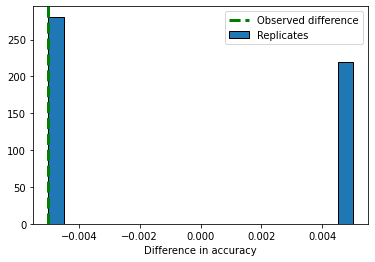

In [108]:
## This code should plot a histogram of the differences between the permuted vectors
## and the location of the observed accuracy difference.
plt.hist(permutationDifferences, 20, label='Replicates', edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [difference], ylim, '--g', linewidth=3, label='Observed difference')
plt.ylim(ylim)
plt.legend()
plt.xlabel('Difference in accuracy')
plt.show()